<a href="https://colab.research.google.com/github/julianaquin/Deep_Learning-UCA_Projects/blob/main/DL2_ATTENDANCE_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Attendance Project**

**Juliana Varela**

The aim of the project is to propose a DL model capable of **filling in the attendance sheet after taking a photo of the classroom.**



*   Step 1: identify the faces in the image and thus the number of people in the room (segmentation problem),

*   Step 2: recognize the gender of each face,

*   Step 3: identify the person's identity (you'll need to describe exactly how to do this and what is the constraint).


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import os
import re
import requests

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from transformers import ViTFeatureExtractor, ViTForImageClassification
from ultralytics import YOLO



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DEEP LEARNING Approach

 For this project the methodology will be the following:

 * Step 1: In order to identify the faces and number of people we will use the model yolov8.

 * Step 2: Then we will proceed to do a gender classification for these faces.

 * Step 3: To identify the person's identity we will train a model of ViT with multiple individual images where the labels will be the name of each person.

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Finding the exact name of my folder
'''!ls -l /content/drive
!ls -l /content/drive/MyDrive/'''

'!ls -l /content/drive\n!ls -l /content/drive/MyDrive/'

In [ ]:
# Accesing the main folder
datasetRoot= '/content/drive/.shortcut-targets-by-id/1-c-cpJ43qE4qG1aMoQtLzz75p8uBULWy/DATA ML DL project n°02 '

In [ ]:
# Printing all contents of main folder
if os.path.exists(datasetRoot):

  print("Shared folder contents:", os.listdir(datasetRoot))
  data = os.listdir(datasetRoot)
  # Getting the labeledPhotos Folder directory
  for item in data:
    if item == 'Labeled Photos':
      labeledPhotos = datasetRoot + '/' + item
else:
    print("Folder not found at:", datasetRoot)

Shared folder contents: ['Video.mp4', 'Labeled Photos', 'Annotated_Images', 'annotations.json', 'XML annotation.zip', 'Yolo annotation.zip', 'labels_my-project-name_2025-03-08-07-18-47.gsheet', 'annotation', '1.xml', '2.xml', '3.xml', '4.xml', '5.xml', '5_.xml', '6.xml', '7.xml', '8.xml', '9.xml', 'processed', 'train', 'test', 'Labeled Photos Folder Raw', 'Individual_photos_Raw', '.ipynb_checkpoints', 'Individual_Images_Cropped', 'Group_Photo_Raw', 'From_V', 'external_images']


In [ ]:
 # Get all of the images in the folder
def find_image_files(directory):

  image_files = []

  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(root, file)
        if "Média" not in file: #ignore files with Média in their name because they are not of the classmates
          image_files.append(image_path)
  return image_files

## Data preparation

### Individual Images and labels

In [ ]:
def extract_name_number(filename):
  # Remove extension and path
  basename = os.path.basename(filename)
  name_with_number = os.path.splitext(basename)[0]

  # We split the name from the numbers
  match = re.match(r"([a-zA-Z]+)(\d+)", name_with_number)
  if match:
    return match.group(1), int(match.group(2))
  return None, None

In [ ]:
def data_augmentation(image):
  new_images = []

  # Flipping the image horizontally
  flipped = cv2.flip(image, 1)
  new_images.append(flipped)

  # This is from https://opencv.courses/blog/image-enhancement-with-opencv/
  for alpha in [1.0, 1.5, 0.9]:
    for beta in [0, 20, -10]:
      brigtht = cv2.convertScaleAbs(image, alpha=1.5, beta= 20)

  new_images.append(brigtht)

  return new_images

In [ ]:
def data_engineering(image_files):

  # We creata dict with defaultdict
  img_data = defaultdict(dict)
  final_data = []

  # We go through the images in the image files previously computed and apply the extract_name_number function
  for img_path in image_files:

    name, number = extract_name_number(img_path)
    if name and number:
      # Read image, resize it and normaiwe it
      img = cv2.imread(img_path)
      img = cv2.resize(img, (224, 224))
      img = img / 255.

      if img is not None:
        # Create name(y) and number(X) into the dict
        img_data[name][number] = []
        # Append the image into it
        img_data[name][number].append(img)

        # Now apply our previous data_augmentation function into it
        augmented_images = data_augmentation(img)
        img_data[name][number].extend(augmented_images) # We add them to our img_data

  # Now go over the img_data
  for name, numbers_dict in img_data.items():
    # This is for the test data, images that are different than the ones before
    sorted_numbers = sorted(numbers_dict.keys())
    # One image by number is added into X, y is the label (name)
    imgs_X = [numbers_dict[num][0] for num in sorted_numbers]
    final_data.append({'X': imgs_X,'y': name})

  return final_data

In [ ]:
individual_image_files = find_image_files(labeledPhotos)
dat = data_engineering(individual_image_files)

In [ ]:
# Class to use data and a tansformer to transform it
class FaceDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Images per label(student names)
        images = sample['X']
        label = sample['y']
        image = random.choice(images)

        # Make image (NumPy array) to PIL and transform it
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to uint8
        image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
# transforming the data into tensors
dataset = FaceDataset(dat, transform)

We visualize the dataset images and their labels

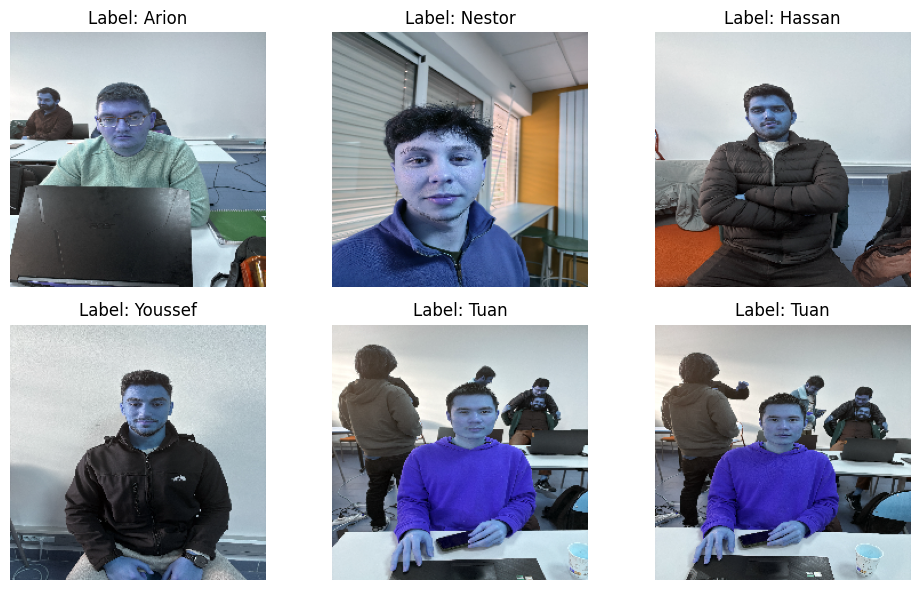

In [ ]:
# Sample a few images and display them
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(6):
    id = random.randint(0, len(dataset)-1)
    image, label = dataset[id]
    # Convert tensor back to image
    image = image.permute(1, 2, 0).numpy()

    row = i // 3
    col = i % 3
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


### Group Images

In [ ]:
group_folders1 = datasetRoot + '/' + 'train'
group_folders2 = datasetRoot + '/' + 'From_V'
group_folders3 = datasetRoot + '/' + 'Group_Photo_Raw'

group_image_files = []
for i in range(1, 4):
  group_folders = locals()[f"group_folders{i}"]
  print(f"Searching for images in: {group_folders}")
  group_image_files.extend(find_image_files(group_folders))

print(f"Found {len(group_image_files)} image files.")

Searching for images in: /content/drive/.shortcut-targets-by-id/1-c-cpJ43qE4qG1aMoQtLzz75p8uBULWy/DATA ML DL project n°02 /train
Searching for images in: /content/drive/.shortcut-targets-by-id/1-c-cpJ43qE4qG1aMoQtLzz75p8uBULWy/DATA ML DL project n°02 /From_V
Searching for images in: /content/drive/.shortcut-targets-by-id/1-c-cpJ43qE4qG1aMoQtLzz75p8uBULWy/DATA ML DL project n°02 /Group_Photo_Raw
Found 82 image files.


## Models

To do the face identification which will allow us to compare the people in the group pictures with their individual photos we will train a ViT (Visual image Transformer model)

In [ ]:
labels = set()
for name in dat:
  labels.add(name['y'])
num_labels = len(labels)

In [ ]:
#Face Classification Using ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
viT_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_labels # Change based on the number of people
)
viT_model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

### Training the viT model

In [ ]:
# We were having some issues with bt-labels variable because its not encoded so we used this to encode them
label_mapping = {name: idx for idx, name in enumerate(set(labl['y'] for labl in dat))}

In [ ]:
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Creating the optimizer and the loss function
optimizer = optim.Adam(viT_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() # Since its a multiclassificcation problem

num_epochs = 5
for epoch in range(num_epochs):
  viT_model.train()
  running_loss = 0.0
  correct, total = 0, 0

  for images, bt_labels in train_loader:
    #pass them to device
    images = images.to(device)
    print(bt_labels)
    bt_labels = torch.tensor([label_mapping[label] for label in bt_labels]).to(device)

    optimizer.zero_grad()

    outputs = viT_model(images).logits
    loss = criterion(outputs, bt_labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    #print(running_loss)
    _, predicted = torch.max(outputs, 1)
    # We get the number of all of the correct predictions
    correct += (predicted == bt_labels).sum().item()
    total += bt_labels.size(0)

  accuracy = 100 * correct / total



('Ubaid', 'Ismail', 'Tuan', 'Youssef', 'Nestor', 'Melissa', 'Usman', 'Arion', 'Algassimou', 'Zeev', 'Gerard', 'Hadi', 'Hassan', 'Hasham', 'Juliana', 'Abhinav')
('Zahid',)
('Melissa', 'Ismail', 'Tuan', 'Nestor', 'Hasham', 'Gerard', 'Zeev', 'Abhinav', 'Hadi', 'Usman', 'Algassimou', 'Hassan', 'Ubaid', 'Zahid', 'Arion', 'Youssef')
('Juliana',)
('Hassan', 'Youssef', 'Gerard', 'Usman', 'Tuan', 'Zahid', 'Ubaid', 'Juliana', 'Hasham', 'Melissa', 'Ismail', 'Zeev', 'Hadi', 'Abhinav', 'Arion', 'Algassimou')
('Nestor',)
('Zahid', 'Ubaid', 'Usman', 'Juliana', 'Arion', 'Hassan', 'Gerard', 'Hadi', 'Abhinav', 'Algassimou', 'Youssef', 'Tuan', 'Ismail', 'Nestor', 'Hasham', 'Zeev')
('Melissa',)
('Zahid', 'Hasham', 'Hadi', 'Usman', 'Arion', 'Algassimou', 'Abhinav', 'Hassan', 'Zeev', 'Ismail', 'Nestor', 'Melissa', 'Youssef', 'Juliana', 'Gerard', 'Tuan')
('Ubaid',)


In [ ]:
correct, accuracy

(9, 52.94117647058823)

### Step 1: Using YOLO for object detection

In order to detect the faces of the people in a group image we will use the model yolov8 which is great for object detection

In [ ]:
yolo = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 376MB/s]


In [ ]:
def detect_faces(group_image):
  #We pass the group images to our yolo model
  results = yolo(group_image)
  faces = []
  # Here we will get the bounding boxes of the detected objects
  for box, clas in zip(results[0].boxes.xyxy, results[0].boxes.cls):
    # 0 class is for people only to makes sure we only detect them
    if clas ==0:
      # Get coordinates
      x1, y1, x2, y2 = map(int, box[:4])
      # Getting the faces region
      faces.append(group_image[y1:y2, x1:x2])

  return faces

We apply our detecting function to our actual group image files

In [ ]:
detected_faces = []

for image_path in group_image_files:
  image = cv2.imread(image_path)
  faces = detect_faces(image)
  detected_faces.extend(faces)
print(f'Total Detected faces:{len(detected_faces)}')


0: 640x640 15 persons, 1 bottle, 1 chair, 4 laptops, 8.0ms
Speed: 4.2ms preprocess, 8.0ms inference, 371.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 persons, 2 backpacks, 2 handbags, 4 chairs, 1 dining table, 2 laptops, 8.0ms
Speed: 4.0ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 persons, 1 backpack, 1 handbag, 1 bottle, 4 chairs, 1 dining table, 2 laptops, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 persons, 1 backpack, 1 handbag, 1 tie, 3 chairs, 1 tv, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 persons, 1 tie, 9 chairs, 2 dining tables, 7 laptops, 1 book, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 persons, 1 chair, 1 dining table, 5 laptops, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference,

We visualize it with a single picture


0: 640x640 15 persons, 1 bottle, 1 chair, 4 laptops, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


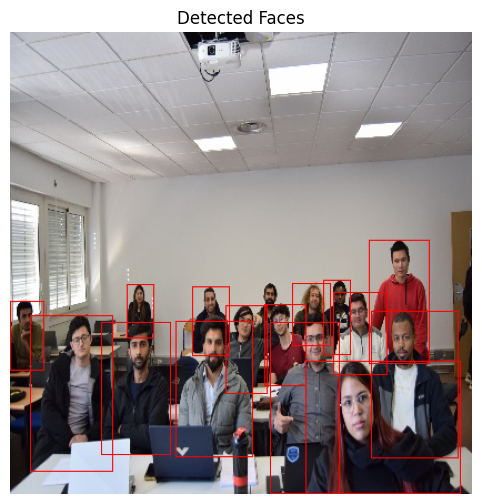

In [ ]:
#Chose and read a group image
chosen_image = cv2.imread(group_image_files[0])
chosen_image_rgb = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2RGB)
results = yolo(chosen_image)
# Show the bounding boxes
for box, clas in zip(results[0].boxes.xyxy, results[0].boxes.cls):
  if clas == 0: # to only see people
    x1, y1, x2, y2 = map(int, box[:4])
    cv2.rectangle(chosen_image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)

plt.figure(figsize=(8, 6))
plt.imshow(chosen_image_rgb)
plt.axis("off")
plt.title('Detected Faces')
plt.show()

### Step 2: Gender Classification

We will use a pretrained gender classification model for this: https://huggingface.co/prithivMLmods/Gender-Classifier-Mini

In [ ]:
!pip install -q transformers torch pillow


In [ ]:
# this code comes from https://huggingface.co/prithivMLmods/Gender-Classifier-Mini
from transformers import AutoImageProcessor
from transformers import SiglipForImageClassification
from transformers.image_utils import load_image

# Load model and processor
model_name = "prithivMLmods/Gender-Classifier-Mini"
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

def gender_classification(image):
    """Predicts gender category for an image."""
    image = Image.fromarray(image).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    labels = {"0": "Female ♀", "1": "Male ♂"}
    predictions = {labels[str(i)]: round(probs[i], 3) for i in range(len(probs))}

    return predictions

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Now we will apply the gender classification to the detected faces by yolo in the group pictures

We visualize the gender classification with some samples

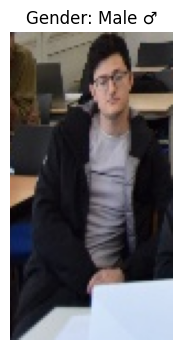

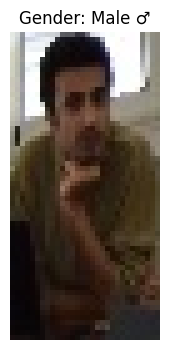

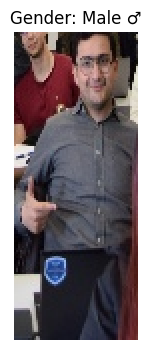

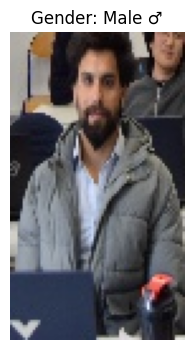

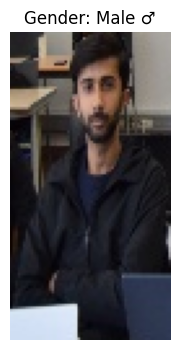

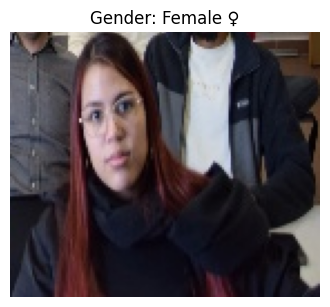

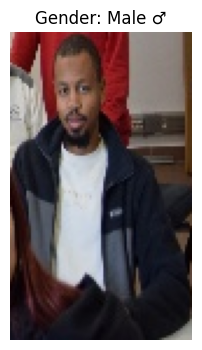

In [ ]:
for i in range(7):
  gender_proba = gender_classification(detected_faces[i])
  predicted_gender = max(gender_proba, key=gender_proba.get)
  probability = gender_proba[predicted_gender]

  # Display the image with bounding box and gender label
  plt.figure(figsize=(4, 4))
  plt.imshow(cv2.cvtColor(detected_faces[i], cv2.COLOR_BGR2RGB))
  plt.title(f"Gender: {predicted_gender}")
  plt.axis('off')
  plt.show()

### Step 3: Using the trained ViT model and YOLO

In [ ]:
def get_names(faces):
  names = []
  for face in faces:
    # Preprocess each invididual face image
    face_pic = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    prep = feature_extractor(images=face_pic, return_tensors="pt").to(device) #pt means type of tensor
    # Predictions from ViT
    with torch.no_grad():
      outputs = viT_model(**prep)
      logits = outputs.logits # get the scores
      # We take the name with the highest probability and predict thats the name
      predicted_class_id = logits.argmax(-1).item()
      #We do the oposite of before and get the actual name label based on the encoded label
      predicted_label = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class_id)]
      names.append(predicted_label)
  return names

In [ ]:
group_labels = []
final_data = []

for image_path in group_image_files:
    image = cv2.imread(image_path)
    faces = detect_faces(image)
    group_labels = get_names(faces)

    group_labels.append(group_labels)
    group_image_file_name = image_path.replace(datasetRoot, '').lstrip(os.sep)
    final_data.append({'group_image_file_name': group_image_file_name, 'student_names': group_labels})


0: 640x640 15 persons, 1 bottle, 1 chair, 4 laptops, 8.3ms
Speed: 3.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 persons, 2 backpacks, 2 handbags, 4 chairs, 1 dining table, 2 laptops, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 persons, 1 backpack, 1 handbag, 1 bottle, 4 chairs, 1 dining table, 2 laptops, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 persons, 1 backpack, 1 handbag, 1 tie, 3 chairs, 1 tv, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 persons, 1 tie, 9 chairs, 2 dining tables, 7 laptops, 1 book, 8.1ms
Speed: 3.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 persons, 1 chair, 1 dining table, 5 laptops, 10.3ms
Speed: 4.0ms preprocess, 10.3ms inference,

## Saving the results

In [ ]:
attendances = final_data
df = pd.DataFrame(attendances)
df.to_csv('attendances.csv', index=False)